In [3]:
import psycopg2
import gc
from psycopg2.extensions import register_adapter, AsIs
from time import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:
def obtainMaxRecords(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT replace(split_part(record, '/',3),'s',''),max(record)
    FROM rstq
    WHERE cast(replace(split_part(record, '/',3),'s','') as integer)
    NOT IN (select subject_id from subjectrecord)
    AND centroid IS NOT NULL
    GROUP BY split_part(record, '/',3)'''
    cur.execute(select_stament)
    subject = []
    for row in cur :
        subject.append({"subject_id":int(row[0]),"record":row[1]})
    conn.close()
    return subject

In [3]:
def insert(words,table,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement = 'INSERT into '+table+' (%s) values %s'
    columns = words.keys()
    values = [words[column] for column in columns]
#    print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
    cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    cur.close()
    conn.close()

In [4]:
def fillsubjectRecord() :
    for subject in obtainMaxRecords() :
        insert(subject,"subjectrecord")

In [5]:
def obtainSubjects(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT subject_id,record FROM subjectrecord'''
    cur.execute(select_stament)
    subject = []
    for row in cur :
        subject.append({"subject_id":int(row[0]),"record":row[1]})
    cur.close()
    conn.close()
    return subject

In [6]:
def patientIsAlive(patient,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT dod "
                      " FROM patients WHERE subject_id = "+str(patient)+" LIMIT 1"
    )
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append(1 if row[0] is not None else 0 )
    cur.close()
    conn.close()
    return select

In [7]:
def obtainWord(subject,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT centroid "
                      " FROM rstq WHERE record='"+str(subject)+"' ORDER BY r_s"
    )
    cur.execute(select_stament)
    centroids = ""
    for row in cur :
        centroid = row[0]
        if centroid is not None :
            centroids= centroids+centroid
    if(len(centroids)<3600): centroids = None
    conn.close()
    return centroids

In [8]:
def deleteWord(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "DELETE FROM subjectwords"
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [9]:
def insertSubjectWords(words,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO subjectwords(word,subject_id,isalive)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(subject_id)s) ,'
                      ' unnest( %(isalive)s)')
    word=[r['word'] for r in words]
    subject_id=[r['subject_id'] for r in words]
    isalive=[r['isalive'] for r in words]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [10]:
def createListOfWords() :
    subjects = obtainSubjects()
    lenSubjects = len(subjects)
    deleteWord()
    i,j=0,0
    words = []
    for subject in subjects :
        subject_id = subject['subject_id']
        print(subject_id)
        isAlive = patientIsAlive(subject_id)
        if isAlive != [] :
            j=j+1
            word = obtainWord(subject['record'])
            if word is not None:
                words.append({'subject_id':subject_id,'word':word,'isalive':isAlive[0]})
    insertSubjectWords(words)
    print()
    print("In a list of "+str(lenSubjects)+" we know the status of "+str(j)+" patients")

In [11]:
def existMatrix(word,subject,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT 1 "
                      " FROM matrix WHERE subject_id='"+str(subject)+"' AND word='"+str(word)+"'"
    )
    cur.execute(select_stament)
    exist = False
    for row in cur :
        exist = True
    cur.close()
    conn.close()
    return exist

In [65]:
def printGroups(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT count(1),LENGTH(word) FROM subjectwords GROUP BY LENGTH(word) ORDER BY LENGTH(word)"
    )
    cur.execute(select_stament)
    words = []
    maximun,minimun = 0,1000000000
    for row in cur :
        words.append({"subjects":row[0],"wordSize":row[1]})
        maximun = maximun if maximun>row[1] else row[1]
        minimun = minimun if minimun<row[1] else row[1]
    cur.close()
    conn.close()
    print("maximun",maximun,"minimun",minimun)
    minimun-=1
    division = (maximun-minimun)/8
    means_men = defaultdict(int) #'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,
    for r in words :
        for x in range(0, 11):
            floor = (division*x)+minimun+1
            top = division*(x+1)+minimun
            if(r['wordSize']>=floor and r['wordSize']<top):
                floor = str(int(floor)).zfill(5)
                top = str(int(top)).zfill(5)
                means_men[floor+"-"+top] += r['subjects']
    columns = sorted(means_men.keys())
    means_men = [means_men[column] for column in sorted(means_men)]
    index = np.arange(len(means_men))
    bar_width = 0.35
    fig, ax = plt.subplots() 
    for i, v in enumerate(means_men):
        ax.text(v-10,i-0.1, str(v), color='white', fontweight='bold')
    plt.barh(index,means_men,label='Pacientes')
    plt.ylabel('Número de latidos')
    plt.xlabel('Pacientes')
    plt.title('Pacientes por Número de latidos')
    plt.yticks(index + bar_width / 2, (columns))
    plt.legend()
#    plt.tight_layout()
    plt.show()

In [13]:
def printWords(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT count(1),LENGTH(word) FROM subjectwords GROUP BY LENGTH(word) ORDER BY LENGTH(word)"
    )
    cur.execute(select_stament)
    x,y = [],[]
    for row in cur :
        x.append(row[0])
        y.append(row[1])
    cur.close()
    conn.close()
    bar_width = 0.35
    plt.plot(x, y, 'ro')
    plt.ylabel('Número de latidos')
    plt.xlabel('Pacientes')
    plt.title('Pacientes por Número de latidos')
    plt.legend()
#    plt.tight_layout()
    plt.show()

In [13]:
t0 = time()
fillsubjectRecord()
print("fillsubjectRecord done in %0.3fs." % (time() - t0))
gc.collect()


fillsubjectRecord done in 96.242s.


0

In [14]:
t0 = time()
createListOfWords()
print("createListOfWords done in %0.3fs." % (time() - t0))

5223
15079
20968
20269
11679
23922
20766
19372
3498
14897
4018
5114
6692
10534
11318
3745
16038
10651
9664
23336
1995
11622
2996
16122
4041
20984
15021
15315
10241
4870
15330
20345
5274
19297
3780
20372
11710
14936
18733
9338
3744
19333
24228
12821
14899
18621
14919
9332
17702
19834
18402
4317
12856
3992
16127
4064
14532
5382
11055
23413
19655
3245
11219
5642
15982
15382
18739
11512
20474
20238
14240
19145
13136
14533
11268
9425
18818
9335
9615
3748
18910
3441
21030
19975
4568
11467
15298
12878
14669
11604
5496
4474
23318
5199
3192
5056
16121
11388
5459
11509
4324
4865
3506
15208
15733
13002
15110
20860
23178
3158
3606
24218
3358
24076
5506
4688
4448
3622
4655
11291
18169
14458
10656
23238
3593
4685
14322
12849
24063
3286
17488
24124
15271
9630
15093
15329
15595
4254
20856
21025
19757
9341
3516
15426
4436
19342
14766
18524
17929
23517
10782
9593
19538
11191
18970
18875
2846
4431
10635
4346
15385
18688
3619
15524
19700
17582
14822
17697
10655
10766
4806
10689
15569
3914
3340
19296
5062


maximun 29296 minimun 3636


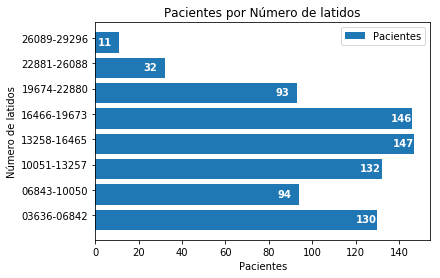

In [66]:
printGroups()

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


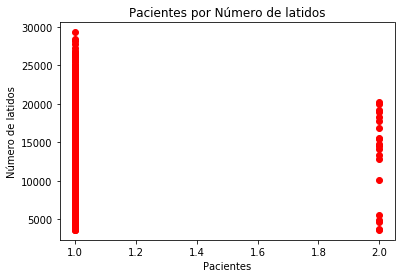

In [14]:
printWords()